## 모델 학습을 위한 데이터 전처리(순정 & 폰트 적용)

In [16]:
import numpy as np
import os
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score

# 3개의 모델 임포트
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# --- 1. 경로 설정 ---
BASE_DIR = '/content/drive/MyDrive/ML_Project'

# [1] 순정 데이터 (Raw) 경로
PATH_TRAIN_RAW = os.path.join(BASE_DIR, 'colored_mnist_train_raw.npz')
PATH_VAL_RAW = os.path.join(BASE_DIR, 'colored_mnist_val_raw.npz')

# [2] 폰트 적용 데이터 (FONT) 경로
PATH_TRAIN_FONT = os.path.join(BASE_DIR, 'colored_mnist_train.npz')
PATH_VAL_FONT = os.path.join(BASE_DIR, 'colored_mnist_val.npz')

print(f"Base Directory: {BASE_DIR}")


# --- 2. 데이터 로드 ---

# 2-1. [순정 데이터] 로드 (Raw)
print("\n--- [1] 순정 데이터(Raw) 로딩 중 ---")
train_raw = np.load(PATH_TRAIN_RAW)
val_raw = np.load(PATH_VAL_RAW)

# 이미지
X_train_raw = train_raw['images']
X_val_raw = val_raw['images']

# 라벨 (숫자, 전경색, 배경색 모두 로드)
y_train_raw_digit = train_raw['labels_digit']
y_train_raw_fg = train_raw['labels_fg']
y_train_raw_bg = train_raw['labels_bg']

y_val_raw_digit = val_raw['labels_digit']
y_val_raw_fg = val_raw['labels_fg']
y_val_raw_bg = val_raw['labels_bg']


# 2-2. [폰트 적용 데이터] 로드 (FONT)
print("\n--- [2] 폰트 데이터(FONT) 로딩 중 ---")
train_font = np.load(PATH_TRAIN_FONT)
val_font = np.load(PATH_VAL_FONT)

# 이미지
X_train_font = train_font['images']
X_val_font = val_font['images']

# 라벨 (숫자, 전경색, 배경색 모두 로드)
y_train_font_digit = train_font['labels_digit']
y_train_font_fg = train_font['labels_fg']
y_train_font_bg = train_font['labels_bg']

y_val_font_digit = val_font['labels_digit']
y_val_font_fg = val_font['labels_fg']
y_val_font_bg = val_font['labels_bg']


# --- 3. 데이터 전처리 (Flatten) ---
print("\n--- 데이터 전처리 (Flattening) ---")
# 색상 분류용 (Color 3D -> 1D Flatten)

# 3-1. 순정 데이터 Flatten (Raw)
X_train_raw_flat = X_train_raw.reshape(X_train_raw.shape[0], -1)
X_val_raw_flat = X_val_raw.reshape(X_val_raw.shape[0], -1)

# 3-2. 폰트적용 데이터 Flatten (font)
X_train_font_flat = X_train_font.reshape(X_train_font.shape[0], -1)
X_val_font_flat = X_val_font.reshape(X_val_font.shape[0], -1)


# --- 4. 로드 결과 확인 ---
print(f"[Raw] 원본 학습 데이터 Shape: {X_train_raw.shape}")
print(f"[Raw] 학습 데이터 Shape: {X_train_raw_flat.shape}")
print(f"[Raw] 검증 데이터 Shape: {X_val_raw_flat.shape}")
print("-" * 30)
print(f"[Font] 원본 학습 데이터 Shape: {X_train_raw.shape}")
print(f"[Font] 학습 데이터 Shape: {X_train_font_flat.shape}")
print(f"[Font] 검증 데이터 Shape: {X_val_font_flat.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base Directory: /content/drive/MyDrive/ML_Project

--- [1] 순정 데이터(Raw) 로딩 중 ---

--- [2] 폰트 데이터(FONT) 로딩 중 ---

--- 데이터 전처리 (Flattening) ---
[Raw] 원본 학습 데이터 Shape: (60000, 28, 28, 3)
[Raw] 학습 데이터 Shape: (60000, 2352)
[Raw] 검증 데이터 Shape: (10000, 2352)
------------------------------
[Font] 원본 학습 데이터 Shape: (60000, 28, 28, 3)
[Font] 학습 데이터 Shape: (60000, 2352)
[Font] 검증 데이터 Shape: (10000, 2352)


## 2. 그레이스케일 없이 모델 학습 (모델 3종)

2-1. 순정 데이터 모델 학습 준비

In [18]:
import time
from tqdm import tqdm
import numpy as np

# =========================================================
# 0. 데이터 및 라벨 준비 확인
# =========================================================
# ※ 아래 변수들이 메모리에 로드되어 있어야 합니다.
# [순정] X_train_raw_flat, y_train_raw_digit, y_train_raw_fg, y_train_raw_bg
# [폰트] X_train_font_flat, y_train_font_digit, y_train_font_fg, y_train_font_bg

NUM_CLASSES_DIGIT = 10  # 숫자 클래스 개수
NUM_CLASSES_COLOR = 7   # 색상 클래스 개수

# 딕셔너리 초기화 (새로 시작)
trained_models = {}

print("--- 학습 데이터셋 설정 완료 ---")


# =========================================================
# 1. [순정 데이터(Pure/Raw)] 작업 목록 정의
# =========================================================
# ※ 순정 데이터(Raw)로 숫자, 전경, 배경 3가지 태스크 모두 수행
print("\n[설정] 1. 순정 데이터(Pure) 작업 목록 생성 중...")

jobs_pure = [
    # --- RandomForest (Pure) ---
    ("RandomForest - Digit (Pure)",
     RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
     X_train_raw_flat, y_train_raw_digit),

    ("RandomForest - FG Color (Pure)",
     RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
     X_train_raw_flat, y_train_raw_fg),

    ("RandomForest - BG Color (Pure)",
     RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
     X_train_raw_flat, y_train_raw_bg),

    # --- XGBoost (Pure) ---
    ("XGBoost - Digit (Pure)",
     xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT),
     X_train_raw_flat, y_train_raw_digit),

    ("XGBoost - FG Color (Pure)",
     xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR),
     X_train_raw_flat, y_train_raw_fg),

    ("XGBoost - BG Color (Pure)",
     xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR),
     X_train_raw_flat, y_train_raw_bg),

    # --- LightGBM (Pure) ---
    ("LightGBM - Digit (Pure)",
     lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbosity=-1),
     X_train_raw_flat, y_train_raw_digit),

    ("LightGBM - FG Color (Pure)",
     lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1),
     X_train_raw_flat, y_train_raw_fg),

    ("LightGBM - BG Color (Pure)",
     lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1),
     X_train_raw_flat, y_train_raw_bg),
]

--- 학습 데이터셋 설정 완료 ---

[설정] 1. 순정 데이터(Pure) 작업 목록 생성 중...


2-2. 폰트 적용 데이터 모델 학습 준비

In [19]:
# =========================================================
# 2. [폰트 데이터(Font/Colored)] 작업 목록 정의
# =========================================================
# ※ 폰트 데이터(Font)로 숫자, 전경, 배경 3가지 태스크 모두 수행
print("[설정] 2. 폰트 데이터(Font) 작업 목록 생성 중...")

jobs_font = [
    # --- RandomForest (Font) ---
    ("RandomForest - Digit (Font)",
     RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
     X_train_font_flat, y_train_font_digit),

    ("RandomForest - FG Color (Font)",
     RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
     X_train_font_flat, y_train_font_fg),

    ("RandomForest - BG Color (Font)",
     RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
     X_train_font_flat, y_train_font_bg),

    # --- XGBoost (Font) ---
    ("XGBoost - Digit (Font)",
     xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT),
     X_train_font_flat, y_train_font_digit),

    ("XGBoost - FG Color (Font)",
     xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR),
     X_train_font_flat, y_train_font_fg),

    ("XGBoost - BG Color (Font)",
     xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR),
     X_train_font_flat, y_train_font_bg),

    # --- LightGBM (Font) ---
    ("LightGBM - Digit (Font)",
     lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbosity=-1),
     X_train_font_flat, y_train_font_digit),

    ("LightGBM - FG Color (Font)",
     lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1),
     X_train_font_flat, y_train_font_fg),

    ("LightGBM - BG Color (Font)",
     lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1),
     X_train_font_flat, y_train_font_bg),
]

[설정] 2. 폰트 데이터(Font) 작업 목록 생성 중...


2-3. 순정 & 폰트 통합 및 실행

In [16]:
# =========================================================
# 3. 통합 및 실행
# =========================================================

# 두 리스트 합치기
all_jobs = jobs_pure + jobs_font

print(f"\n--- 총 {len(all_jobs)}개 모델 학습 시작 (Pure 9개 + Font 9개) ---")

for name, model, X_train, y_train in tqdm(all_jobs, desc="Overall Training Progress"):
    # 학습 수행
    model.fit(X_train, y_train)

    # 모델 저장
    trained_models[name] = model

print("\n--- 모든 모델 학습 완료 ---")
print(f"최종 저장된 모델 개수: {len(trained_models)}개")


--- 총 18개 모델 학습 시작 (Pure 9개 + Font 9개) ---


Overall Training Progress: 100%|██████████| 18/18 [1:09:36<00:00, 232.05s/it]


--- 모든 모델 학습 완료 ---
최종 저장된 모델 개수: 18개


## 그레이스케일 미적용 모델 성능 평가

In [21]:
import pandas as pd
import warnings
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 평가 결과를 저장할 리스트 초기화
evaluation_records = []

def evaluate_and_log(model_name, model_obj):
    print(f"\n===== Evaluating: {model_name} =====")

    # ---------------------------------------------------------
    # 1. 모델 이름(Pure/Font)에 따라 '입력 데이터(X)' 선택
    # ---------------------------------------------------------
    if "(Pure)" in model_name:
        current_X = X_val_raw_flat       # 순정 검증 데이터
        data_type = "Pure"
    elif "(Font)" in model_name:
        # ※ 주의: 사용자 환경 변수명에 맞춰 수정하세요 (X_val_colored_flat 또는 X_val_font_flat)
        current_X = X_val_font_flat      # 폰트 검증 데이터
        data_type = "Font"
    else:
        print(f"Error: 데이터 타입을 알 수 없습니다. ({model_name})")
        return

    # ---------------------------------------------------------
    # 2. 태스크(Digit/FG/BG)에 따라 '정답 라벨(y)' 선택
    # ---------------------------------------------------------
    if "Digit" in model_name:
        # 데이터 타입에 맞춰 정답지 선택
        current_y = y_val_raw_digit if data_type == "Pure" else y_val_font_digit
        task_name = "Digit"
    elif "FG Color" in model_name:
        current_y = y_val_raw_fg if data_type == "Pure" else y_val_font_fg
        task_name = "FG Color"
    elif "BG Color" in model_name:
        current_y = y_val_raw_bg if data_type == "Pure" else y_val_font_bg
        task_name = "BG Color"
    else:
        print(f"Error: 태스크를 알 수 없습니다. ({model_name})")
        return

    # ---------------------------------------------------------
    # 3. 예측 및 성능 평가
    # ---------------------------------------------------------
    # 예측 수행
    y_pred = model_obj.predict(current_X)

    # 기본 성능 지표
    acc = accuracy_score(current_y, y_pred)
    print(classification_report(current_y, y_pred, digits=4, zero_division=0))

    # AUC 계산
    auc_score = 0
    if hasattr(model_obj, "predict_proba"):
        try:
            y_proba = model_obj.predict_proba(current_X)
            auc_score = roc_auc_score(current_y, y_proba, multi_class='ovr', average='weighted')
            print(f"** Weighted-Average AUC: {auc_score:.4f} **")
        except Exception as e:
            print(f"※ AUC Calculation Error: {e}")

    # ---------------------------------------------------------
    # 4. 결과 기록
    # ---------------------------------------------------------
    model_base = model_name.split(" - ")[0]

    evaluation_records.append({
        "Model": model_base,
        "Task": task_name,
        "Data Type": data_type,
        "Accuracy": round(acc, 4),
        "AUC": round(auc_score, 4)
    })

print("\n--- 최종 성능 평가 (Validation Set) 시작 ---")

# =========================================================
#  경고 메시지 제어 및 루프 실행
# =========================================================
with warnings.catch_warnings():
    # 1. "X does not have valid feature names" 경고 메시지 무시 (LightGBM 등)
    warnings.filterwarnings("ignore", message=".*X does not have valid feature names.*")

    # 2. (선택 사항) UndefinedMetricWarning도 무시하고 싶다면 주석 해제
    # warnings.filterwarnings("ignore", message=".*Precision and F-score are ill-defined.*")

    # 3. 저장된 모든 모델 순회하며 평가
    for name, model in trained_models.items():
        evaluate_and_log(name, model)




--- 최종 성능 평가 (Validation Set) 시작 ---

===== Evaluating: RandomForest - Digit (Pure) =====
              precision    recall  f1-score   support

           0     0.9562    0.9766    0.9663       984
           1     0.9525    0.9867    0.9693       976
           2     0.9346    0.9309    0.9327      1013
           3     0.9231    0.9185    0.9208      1019
           4     0.9280    0.9391    0.9335      1002
           5     0.9368    0.9406    0.9387       993
           6     0.9435    0.9719    0.9575      1031
           7     0.9395    0.9203    0.9298       979
           8     0.9383    0.8801    0.9083       951
           9     0.9026    0.8897    0.8961      1052

    accuracy                         0.9354     10000
   macro avg     0.9355    0.9355    0.9353     10000
weighted avg     0.9352    0.9354    0.9352     10000

** Weighted-Average AUC: 0.9956 **

===== Evaluating: RandomForest - FG Color (Pure) =====
              precision    recall  f1-score   support

    



=== [최종 결과표] 순정(Pure) vs 폰트(Font) 성능 비교 ===


Data Type                Pure    Font  Diff (Font-Pure)
Task     Model                                         
BG Color LightGBM      1.0000  1.0000            0.0000
         RandomForest  1.0000  1.0000            0.0000
         XGBoost       1.0000  1.0000            0.0000
Digit    LightGBM      0.9388  0.9482            0.0094
         RandomForest  0.9354  0.9472            0.0118
         XGBoost       0.9519  0.9591            0.0072
FG Color LightGBM      1.0000  0.9999           -0.0001
         RandomForest  0.9997  0.9999            0.0002
         XGBoost       1.0000  0.9997           -0.0003



=== [시각화] 성능 비교 그래프 ===


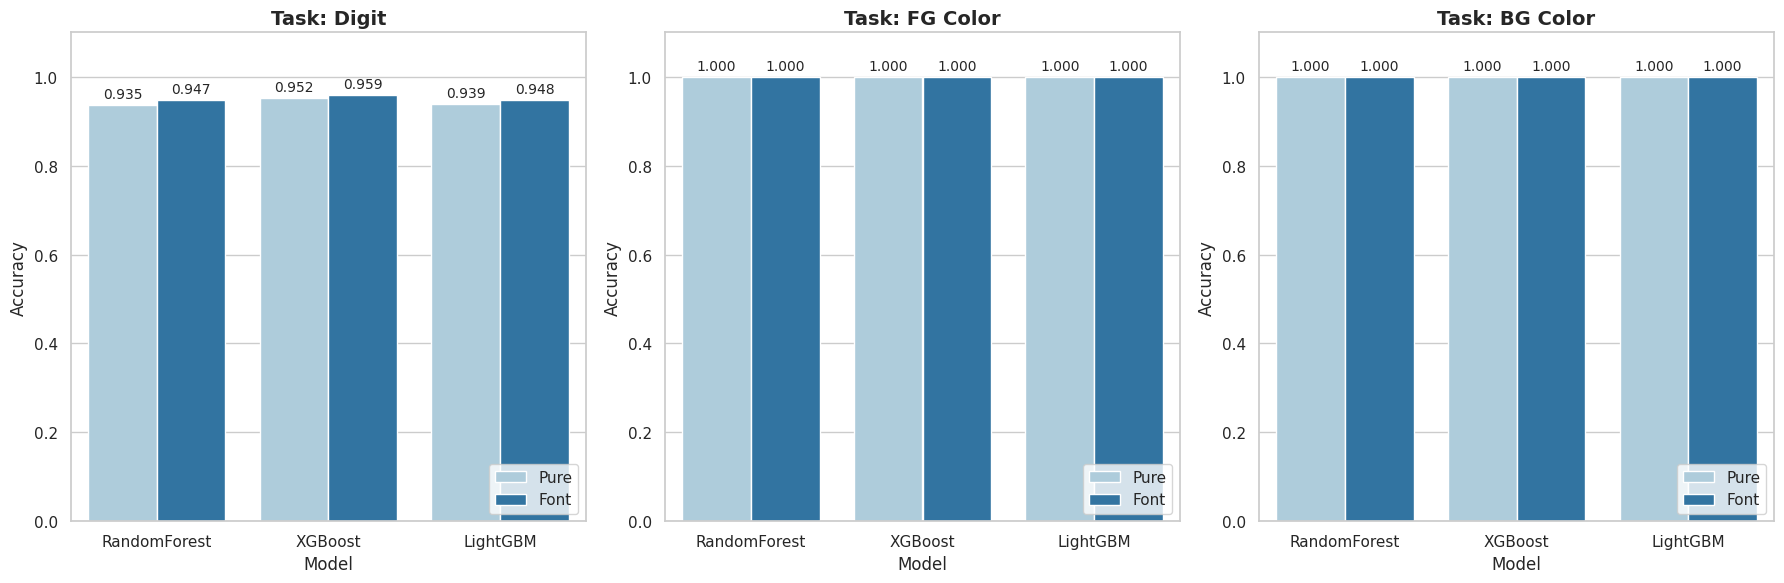

In [22]:
# =========================================================
# [결과 1] 표 출력 (Pure -> Font 순서 정렬)
# =========================================================
print("\n\n=== [최종 결과표] 순정(Pure) vs 폰트(Font) 성능 비교 ===")
df_eval = pd.DataFrame(evaluation_records)

# 1. 피벗 테이블 생성
pivot_table = df_eval.pivot_table(
    index=["Task", "Model"],
    columns="Data Type",
    values="Accuracy"
)

# 2. 차이 계산
if "Pure" in pivot_table.columns and "Font" in pivot_table.columns:
    pivot_table["Diff (Font-Pure)"] = pivot_table["Font"] - pivot_table["Pure"]

# 3. [핵심] 컬럼 순서 강제 지정 (Pure가 먼저 오게)
# 존재하는 컬럼만 선택하여 에러 방지
desired_order = ["Pure", "Font", "Diff (Font-Pure)"]
final_cols = [col for col in desired_order if col in pivot_table.columns]
pivot_table = pivot_table[final_cols]

display(pivot_table)


# =========================================================
# [결과 2] 그래프 시각화 (Seaborn Bar Plot)
# =========================================================
print("\n\n=== [시각화] 성능 비교 그래프 ===")

# 그래프 스타일 설정
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 6))

# 태스크 목록 정의
tasks = ["Digit", "FG Color", "BG Color"]

for i, task in enumerate(tasks):
    plt.subplot(1, 3, i+1) # 1행 3열 구조

    # 해당 태스크 데이터만 필터링
    task_data = df_eval[df_eval["Task"] == task]

    # 막대 그래프 그리기 (x=모델, y=정확도, hue=데이터타입)
    # palette="Paired": 파란색/하늘색 계열로 짝지어 보여줌
    ax = sns.barplot(data=task_data, x="Model", y="Accuracy", hue="Data Type",
                     palette="Paired", hue_order=["Pure", "Font"])

    plt.title(f"Task: {task}", fontsize=14, fontweight='bold')
    plt.ylim(0, 1.1) # y축 범위 0~1.1
    plt.legend(loc='lower right')

    # 막대 위에 수치 표시 (Bar Label)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()


--- [1/2] 순정 데이터(Pure) 혼동행렬 생성 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


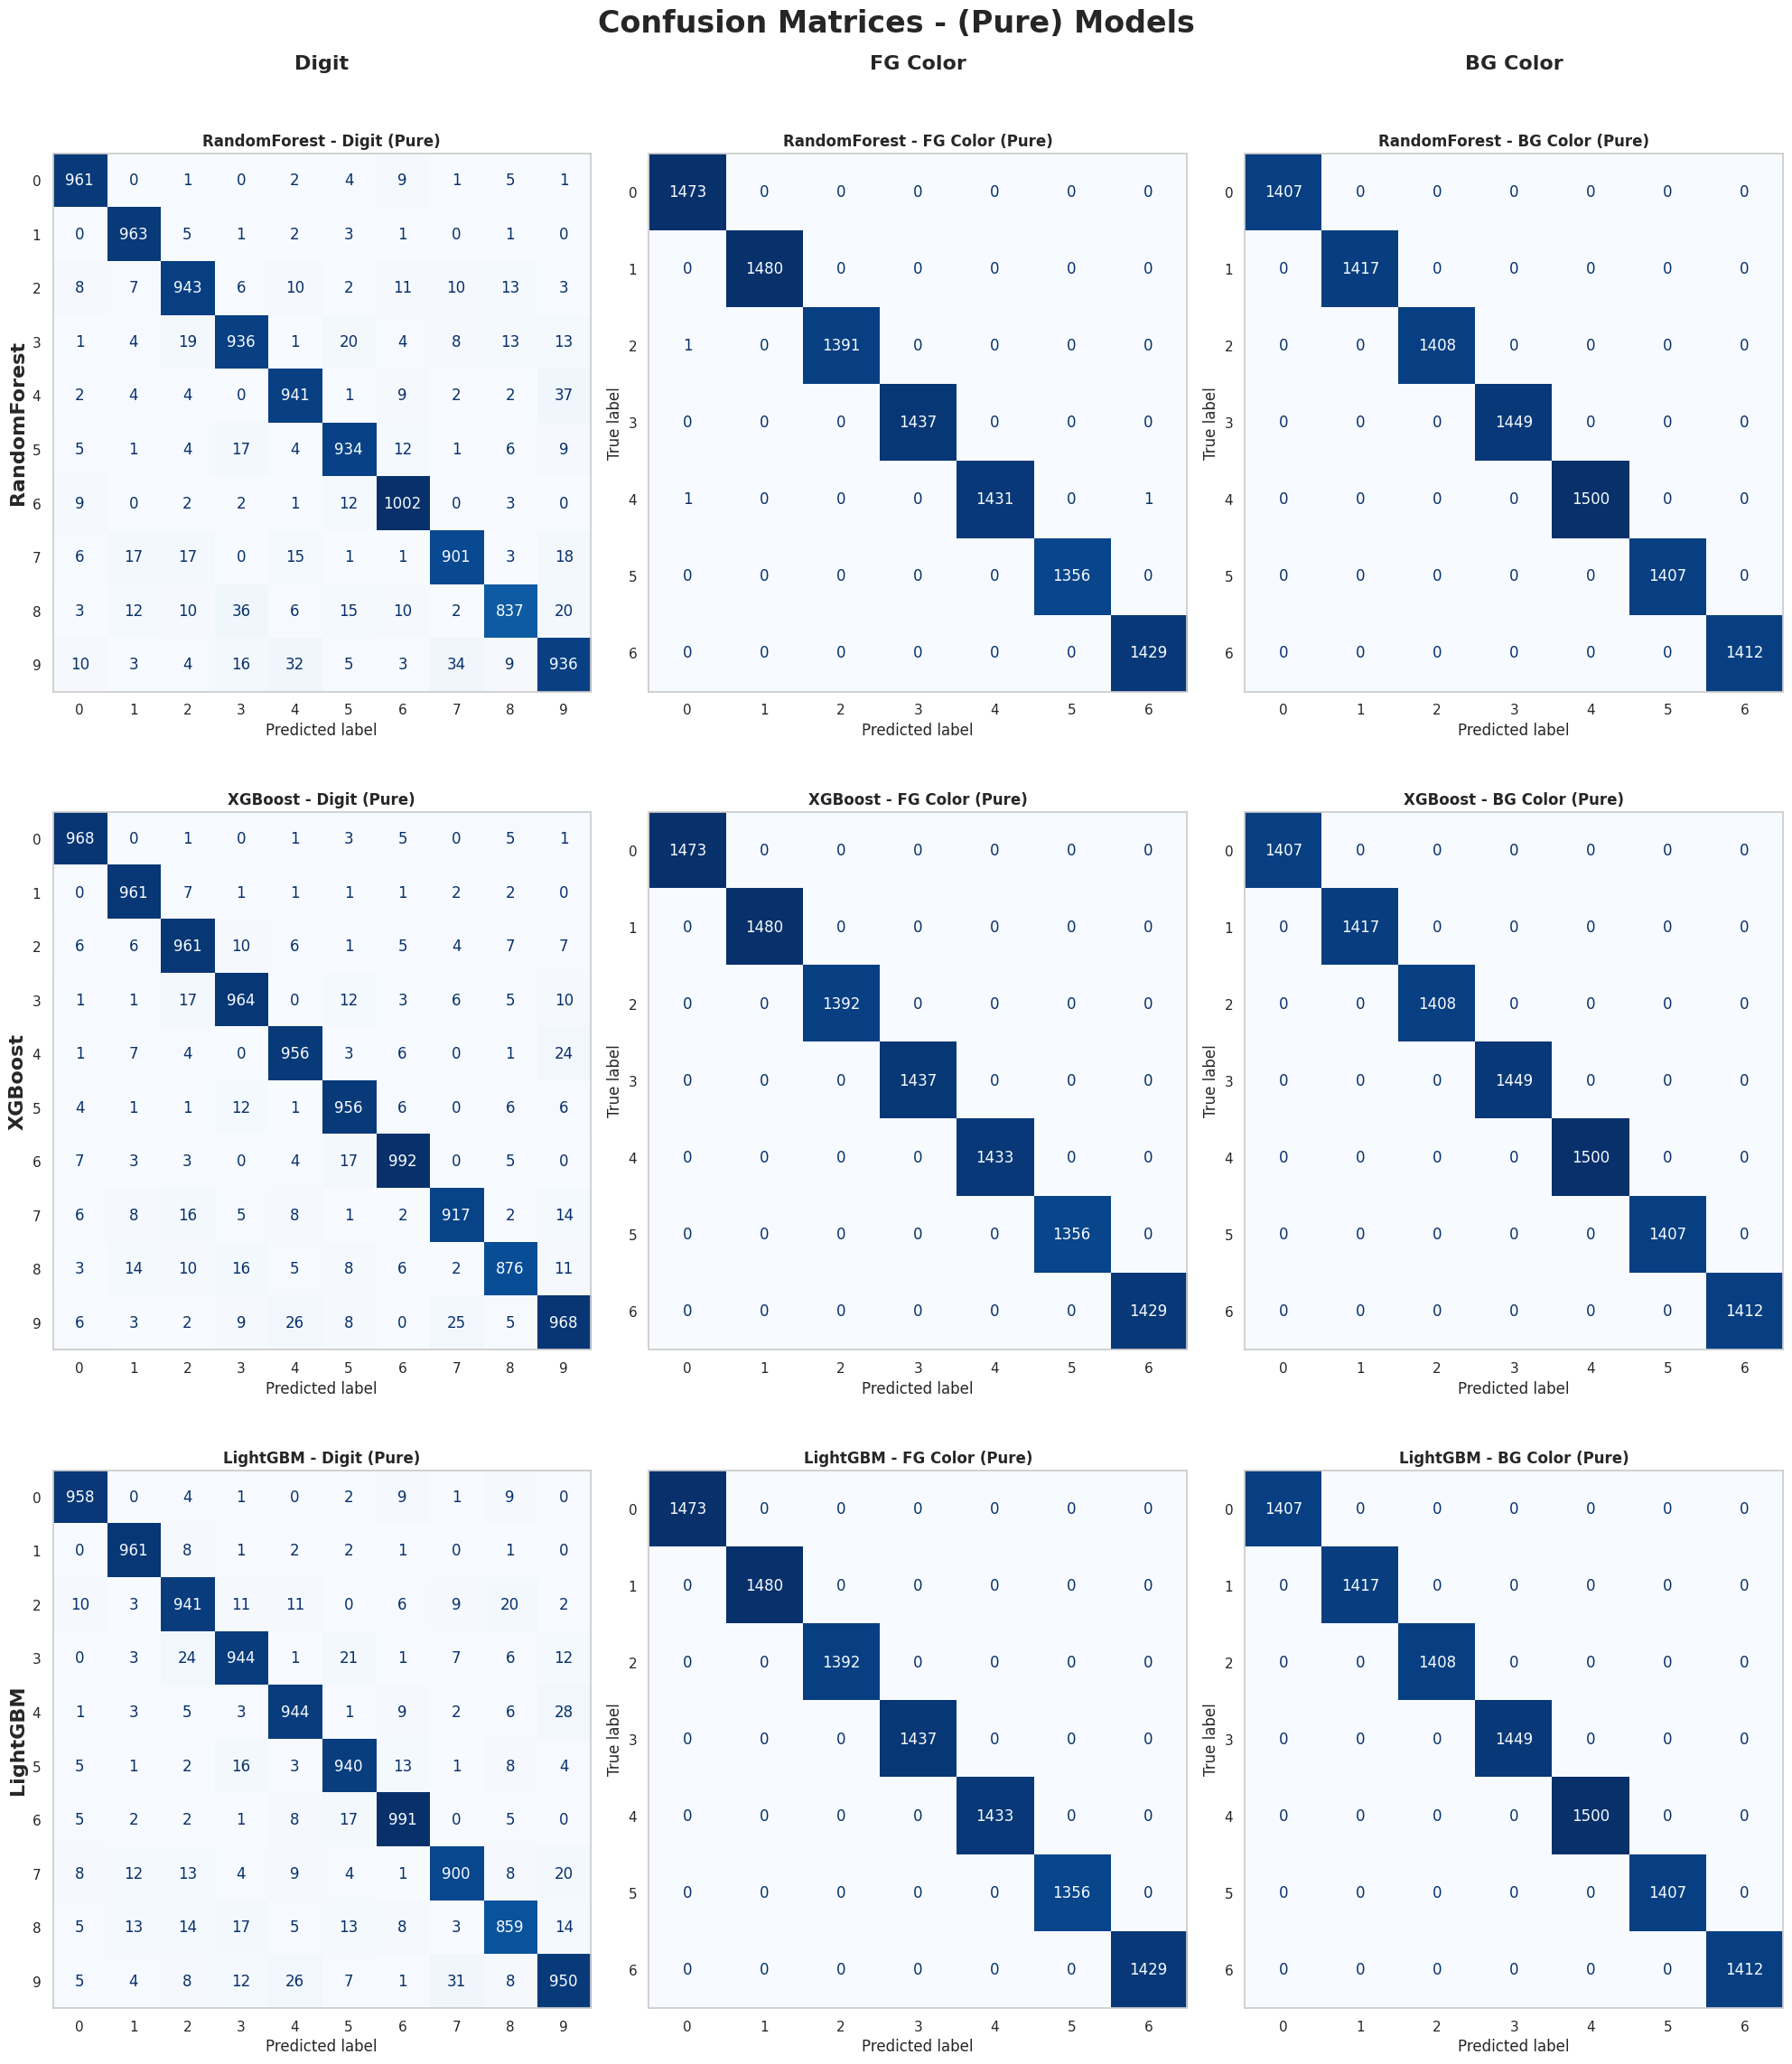


--- [2/2] 폰트 데이터(Font) 혼동행렬 생성 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


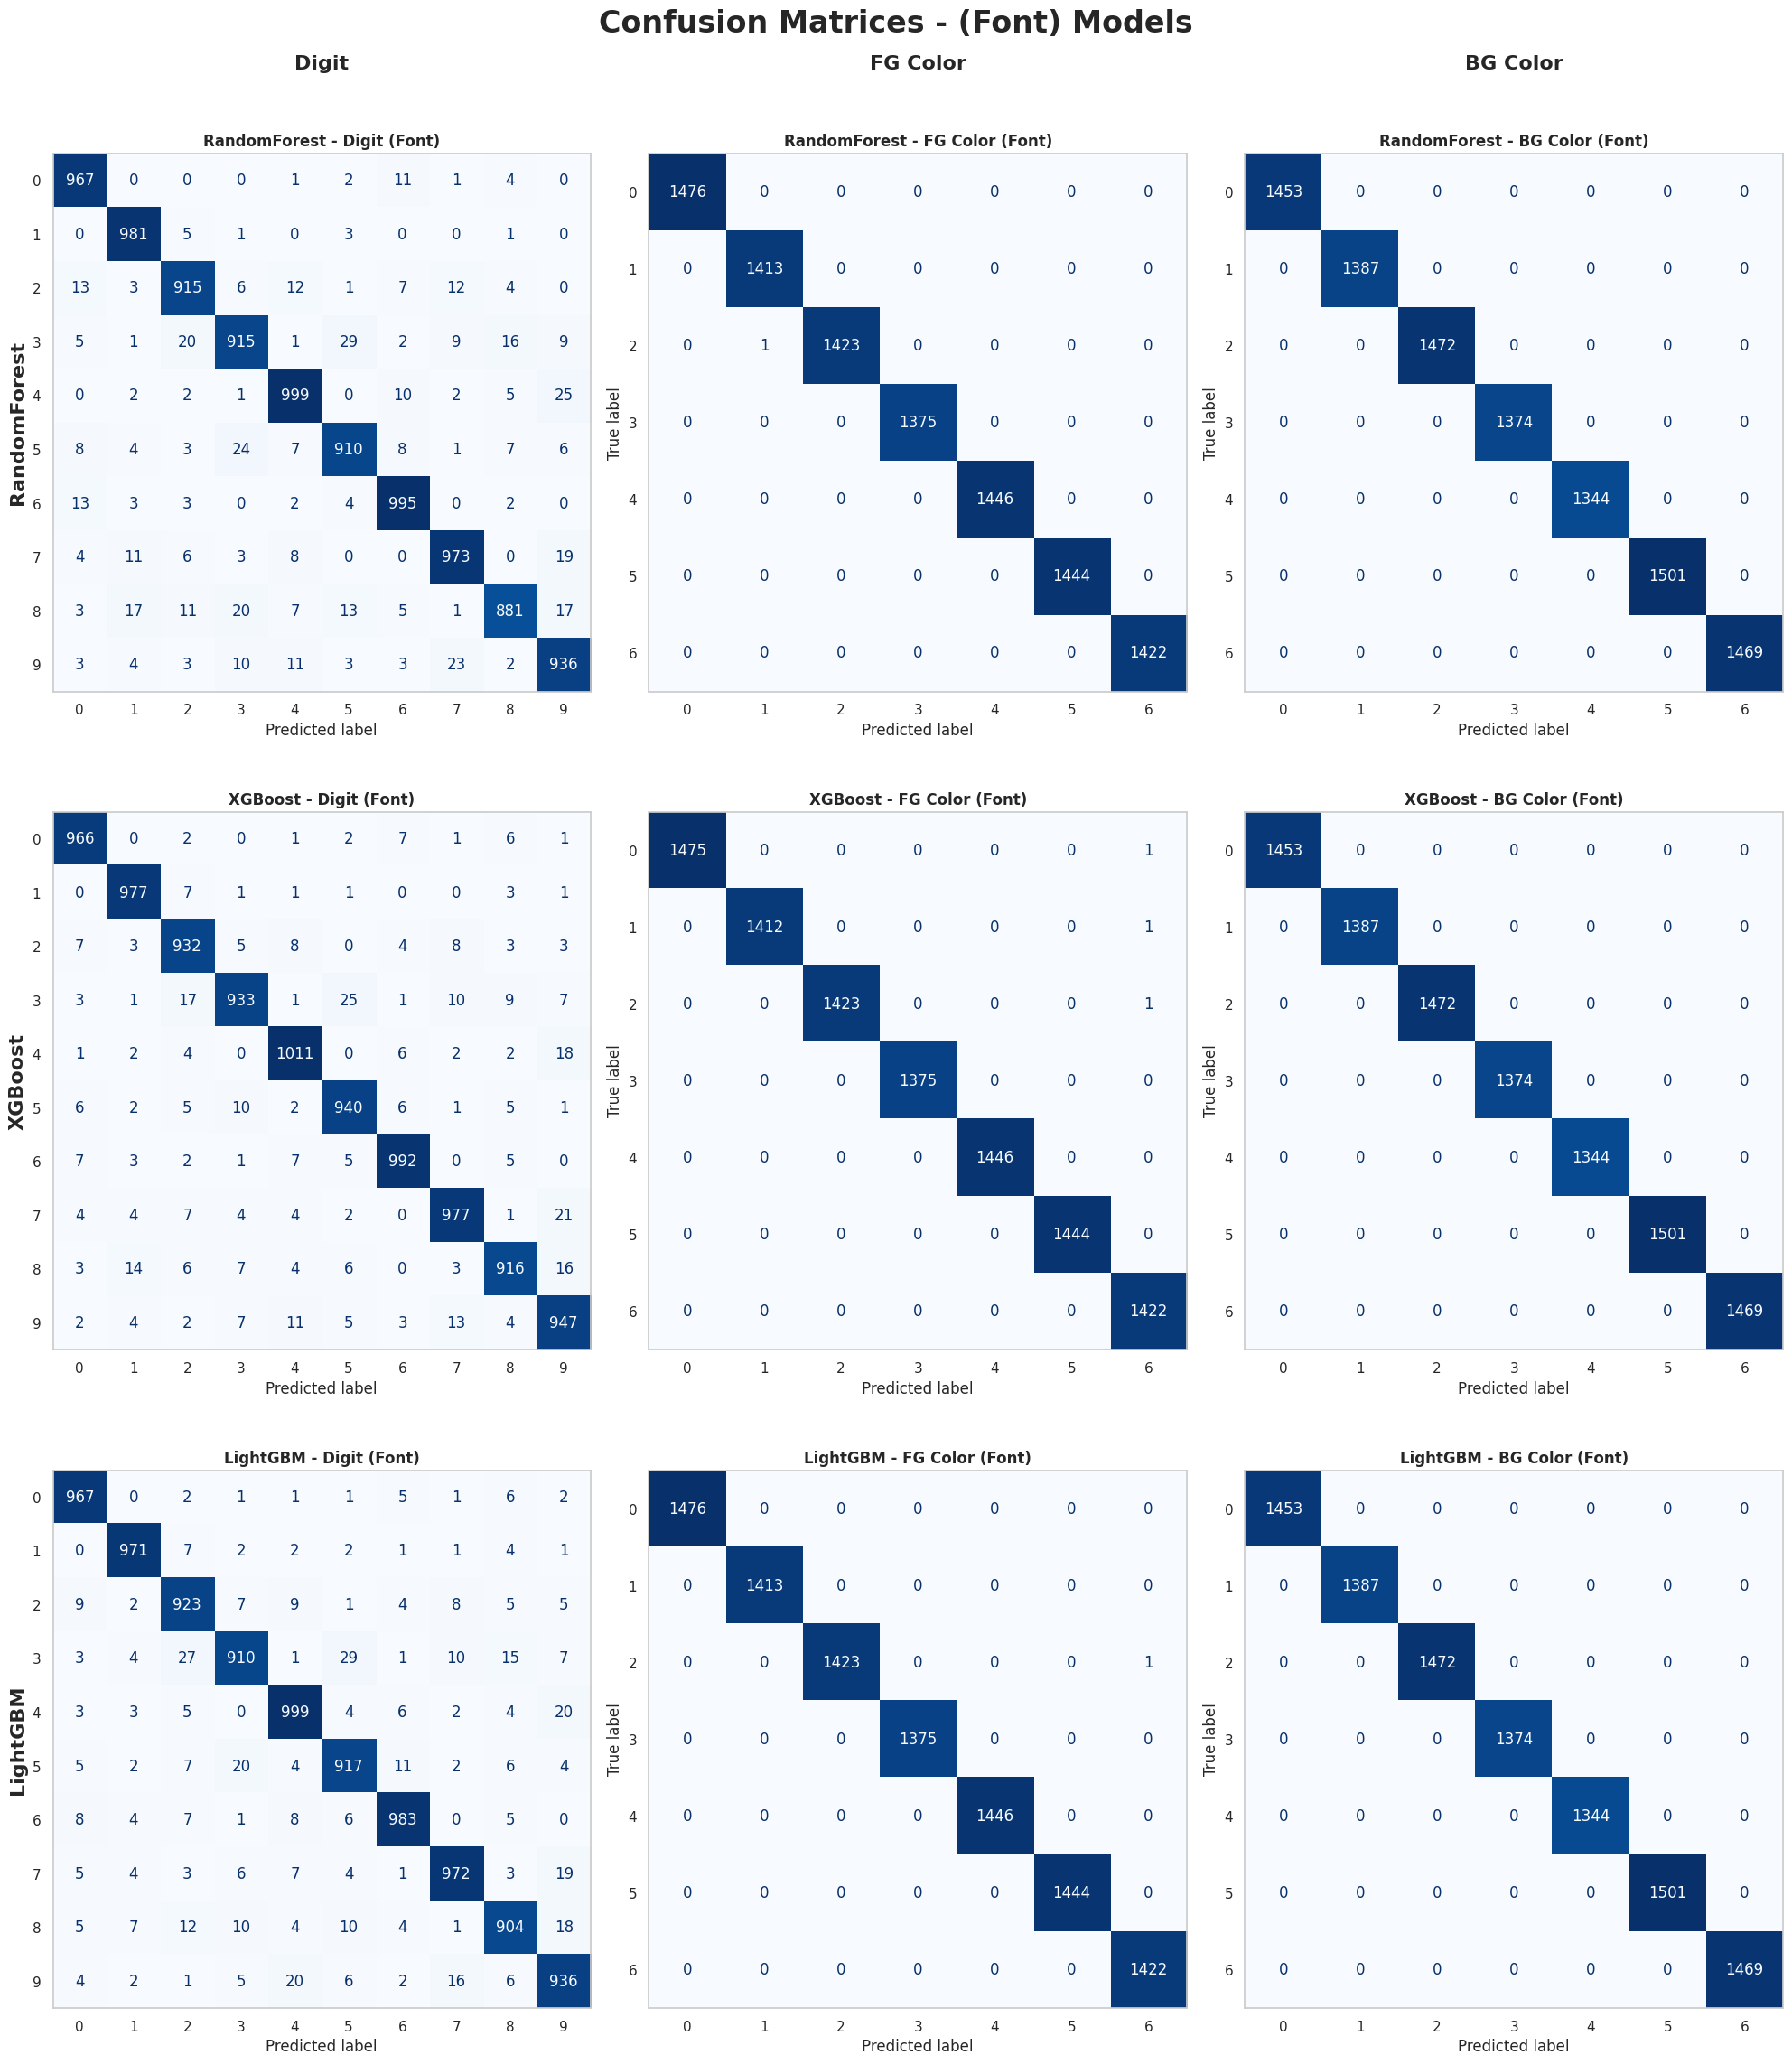

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# --- [설정 영역] ---
# 행(Row): 모델 3종
model_rows = ["RandomForest", "XGBoost", "LightGBM"]
# 열(Col): 태스크 3종
task_cols = ["Digit", "FG Color", "BG Color"]

# -------------------------------------------------------------------------
# 함수 정의: 데이터 타입(Pure/Font)에 따라 3x3 그리드를 그리는 함수
# -------------------------------------------------------------------------
def plot_confusion_matrix_grid(data_type_tag, X_val, y_val_d, y_val_f, y_val_b):
    """
    data_type_tag: "(Pure)" 또는 "(Font)"
    X_val: 해당 타입의 검증용 이미지 데이터 (Flatten)
    y_val_d, y_val_f, y_val_b: 해당 타입의 정답 라벨 (Digit, FG, BG)
    """

    # 3x3 그리드 생성
    fig, axes = plt.subplots(len(model_rows), len(task_cols), figsize=(20, 24))

    # 전체 제목
    fig.suptitle(f"Confusion Matrices - {data_type_tag} Models", fontsize=24, fontweight='bold', y=0.96)

    for row_idx, model_base in enumerate(model_rows):
        for col_idx, task_name in enumerate(task_cols):

            ax = axes[row_idx, col_idx]

            # 1. 모델 이름 조합 (예: "RandomForest - Digit (Pure)")
            full_model_name = f"{model_base} - {task_name} {data_type_tag}"

            # 2. 모델 존재 여부 확인
            if full_model_name not in trained_models:
                print(f"Warning: '{full_model_name}' 모델을 찾을 수 없습니다. (Skip)")
                ax.axis('off')
                continue

            model = trained_models[full_model_name]

            # 3. 태스크에 따른 정답 라벨(y) 선택
            if task_name == "Digit":
                y_target = y_val_d
            elif task_name == "FG Color":
                y_target = y_val_f
            else: # BG Color
                y_target = y_val_b

            # 4. 예측 수행
            y_pred = model.predict(X_val)

            # 5. 혼동행렬 계산
            cm = confusion_matrix(y_target, y_pred)

            # 6. 시각화
            # display_labels=model.classes_ : 모델이 학습한 클래스 순서대로 라벨 자동 매칭 (에러 방지)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
            disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
            ax.grid(False)

            # 7. 타이틀 및 축 꾸미기
            ax.set_title(full_model_name, fontsize=12, fontweight='bold')

            # 첫 열에만 모델 이름 표시
            if col_idx == 0:
                ax.set_ylabel(model_base, fontsize=16, fontweight='bold')

            # 첫 행에만 태스크 이름 표시
            if row_idx == 0:
                 ax.text(0.5, 1.15, task_name, transform=ax.transAxes,
                         fontsize=16, fontweight='bold', ha='center', va='bottom')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92) # 제목 공간 확보
    plt.show()

# =========================================================================
# [실행 1] 순정 데이터(Pure) 모델 시각화
# =========================================================================
print("\n--- [1/2] 순정 데이터(Pure) 혼동행렬 생성 ---")
plot_confusion_matrix_grid(
    data_type_tag="(Pure)",
    X_val=X_val_raw_flat,       # 순정 입력 데이터
    y_val_d=y_val_raw_digit,    # 순정 정답지
    y_val_f=y_val_raw_fg,
    y_val_b=y_val_raw_bg
)

# =========================================================================
# [실행 2] 폰트 데이터(Font) 모델 시각화
# =========================================================================
print("\n--- [2/2] 폰트 데이터(Font) 혼동행렬 생성 ---")
plot_confusion_matrix_grid(
    data_type_tag="(Font)",
    X_val=X_val_colored_flat,   # 폰트 입력 데이터 (또는 X_val_font_flat)
    y_val_d=y_val_colored_digit, # 폰트 정답지
    y_val_f=y_val_colored_fg,
    y_val_b=y_val_colored_bg
)

순정 데이터 vs 폰트 적용 데이터
=> 폰트 적용시 성능 미미하게 향상